## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [79]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [80]:
original_data = original_data.dropna()

In [81]:
# Pair each feature vector with the corresponding label (whether the outcome_type is 'adoption' or not)
data_features = original_data.copy()
data_features['adopted'] = original_data.outcome_type.apply(lambda r: 1 if r == 'Adoption' else 0)
data_features.drop("outcome_type", axis = 1, inplace=True)
data_features

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
0,Neutered Male,10.000000,Dog,Normal,Stray,Neutered Male,10.000000,2017,1.0,0.588194,0
1,Neutered Male,7.000000,Dog,Normal,Public Assist,Neutered Male,7.000000,2014,2.0,1.259722,0
2,Neutered Male,6.000000,Dog,Normal,Public Assist,Neutered Male,6.000000,2014,3.0,1.113889,0
3,Neutered Male,10.000000,Dog,Normal,Owner Surrender,Neutered Male,10.000000,2014,1.0,4.970139,0
4,Neutered Male,16.000000,Dog,Injured,Public Assist,Neutered Male,16.000000,2013,1.0,0.119444,0
...,...,...,...,...,...,...,...,...,...,...,...
79667,Unknown,0.038356,Cat,Normal,Stray,Unknown,0.038356,2018,1.0,0.077083,0
79668,Unknown,2.000000,Other,Normal,Wildlife,Unknown,2.000000,2018,1.0,0.053472,0
79669,Unknown,1.000000,Other,Normal,Wildlife,Unknown,1.000000,2018,1.0,0.047917,0
79670,Intact Male,0.821918,Dog,Normal,Stray,Intact Male,0.410959,2018,1.0,1.762500,0


In [82]:
# Split into training and test sets
mask = np.random.rand(len(original_data)) < 0.8
train_data = data_features[mask].reset_index(drop=True)
test_data = data_features[~mask].reset_index(drop=True)

print(len(train_data))
print(len(test_data))

63635
16026


In [83]:
# Convert categorical variables into dummy/indicator variables
training_categorical = pd.get_dummies(train_data, columns=['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake'])
train_features = training_categorical.drop('adopted', axis=1)

# Make sure that only the features available in the training data are used
testing_categorical = pd.get_dummies(train_data, columns=['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake'])
test_features = testing_categorical.drop('adopted', axis=1)


# Standardize so that each feature has a mean of 0 and a variance of 1
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.711870,2.730019,1.201219,-0.278024,-0.392097,-0.362751,-0.37261,1.347610,-0.687049,-0.306784,...,-0.055155,-0.481135,-0.259228,0.651454,-0.214455,-0.650989,-0.681455,2.292154,-0.402313,-0.306784
1,1.676891,1.692669,-1.100739,1.911857,-0.375715,-0.362751,-0.37261,1.347610,-0.687049,-0.306784,...,-0.055155,-0.481135,3.857554,-1.535005,-0.214455,-0.650989,-0.681455,2.292154,-0.402313,-0.306784
2,1.331898,1.346886,-1.100739,4.101739,-0.379273,-0.362751,-0.37261,1.347610,-0.687049,-0.306784,...,-0.055155,-0.481135,3.857554,-1.535005,-0.214455,-0.650989,-0.681455,2.292154,-0.402313,-0.306784
3,4.781827,4.804717,-1.868058,-0.278024,-0.403532,-0.362751,-0.37261,1.347610,-0.687049,-0.306784,...,-0.055155,-0.481135,3.857554,-1.535005,-0.214455,-0.650989,-0.681455,2.292154,-0.402313,-0.306784
4,4.436834,4.458934,-1.868058,-0.278024,-0.385202,-0.362751,-0.37261,-0.742043,1.455477,-0.306784,...,-0.055155,-0.481135,-0.259228,0.651454,-0.214455,-0.650989,-0.681455,-0.436264,2.485585,-0.306784


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [85]:
# Train a logistic regression classifier on the training set
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,training_categorical.adopted)

LogisticRegression(max_iter=10000)

In [ ]:
# Apply on the test set
logistic.predict_proba(test_features_std)

array([[8.46834855e-01, 1.53165145e-01],
       [9.65706326e-01, 3.42936737e-02],
       [9.57061270e-01, 4.29387302e-02],
       ...,
       [9.99285472e-01, 7.14528411e-04],
       [9.02371234e-01, 9.76287657e-02],
       [7.37925667e-01, 2.62074333e-01]])

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

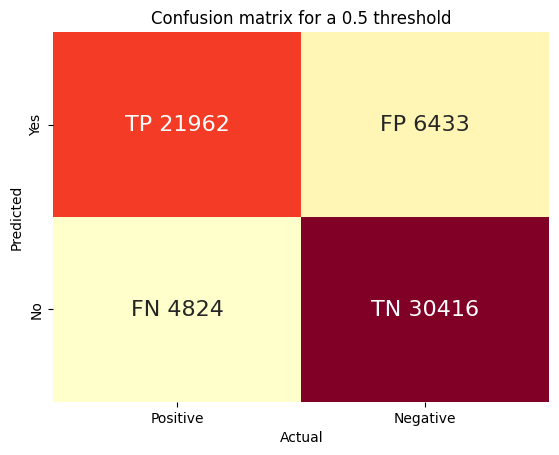

In [ ]:
# Display the confusion matrix
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')



confusion_05 = compute_confusion_matrix(testing_categorical.adopted, logistic.predict_proba(test_features_std), decision_threshold=0.5)

plt.figure() 
ax = plot_confusion_matrix(confusion_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')
# oupsi c'est vraiment pas les mêmes valeurs que la correction

In [100]:
# Manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class
# Accuracy A = (TP + TN) / N
accuracy = (confusion_05[0,0] + confusion_05[1,1]) / (confusion_05[0,0] + confusion_05[0,1] + confusion_05[1,0] + confusion_05[1,1])
print("Accuracy : ", accuracy)
print("\n")

# Precision with respect to the positive class P_pos = TP / (TP + FP)
precision_pos = confusion_05[0,0] / (confusion_05[0,0] + confusion_05[0,1])
print("Precision with respect to the positive class : ", precision_pos)

# Recall with respect to the positive class R_pos = TP / (TP + FN)
recall_pos = confusion_05[0,0] / (confusion_05[0,0] + confusion_05[1,0])
print("Recall with respect to the positive class : ", recall_pos)

# F1-score with respect to the positive class f1_score_pos = 2 * P_pos * R_pos / (P_pos + R_pos)
f1_score_pos = 2*precision_pos*recall_pos / (precision_pos + recall_pos)
print("F1-score with respect to the positive class : ", f1_score_pos)
print("\n")

# Precision with respect to the negative class P_neg = TN / (TN + FN)
precision_neg = confusion_05[1,1] / (confusion_05[1,1] + confusion_05[1,0])
print("Precision with respect to the negative class : ", precision_neg)

# Recall with respect to the negative class R_neg = TN / (TN + FP)
recall_neg = confusion_05[1,1] / (confusion_05[1,1] + confusion_05[0,1])
print("Recall with respect to the negative class : ", recall_neg)

# F1-score with respect to the negative class f1_score_neg = 2 * P_neg * R_neg / (P_neg + R_neg)
f1_score_neg = 2*precision_neg*recall_neg / (precision_neg + recall_neg)
print("F1-score with respect to the negative class : ", f1_score_neg)


# weird weird, all scores are pretty similar but the confusion matrix isn't

Accuracy :  0.8231004950106073


Precision with respect to the positive class :  0.7734460292304983
Recall with respect to the positive class :  0.8199059210035093
F1-score with respect to the positive class :  0.7959986227143401


Precision with respect to the negative class :  0.8631101021566402
Recall with respect to the negative class :  0.8254226709001601
F1-score with respect to the negative class :  0.8438458017173216


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [102]:
threshold = np.linspace(0, 1, 100)



def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]




columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(testing_categorical.adopted, logistic.predict_proba(test_features_std), t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'Accuracy')

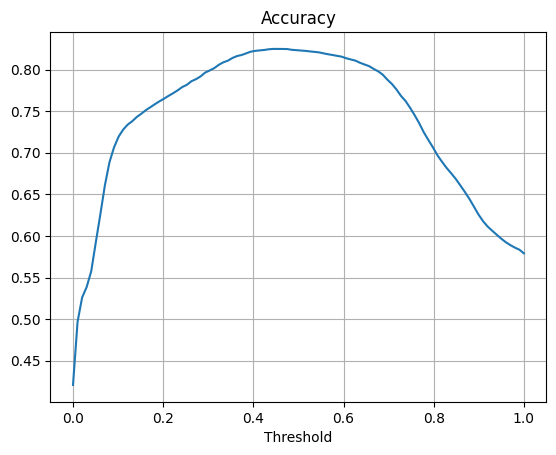

In [103]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')

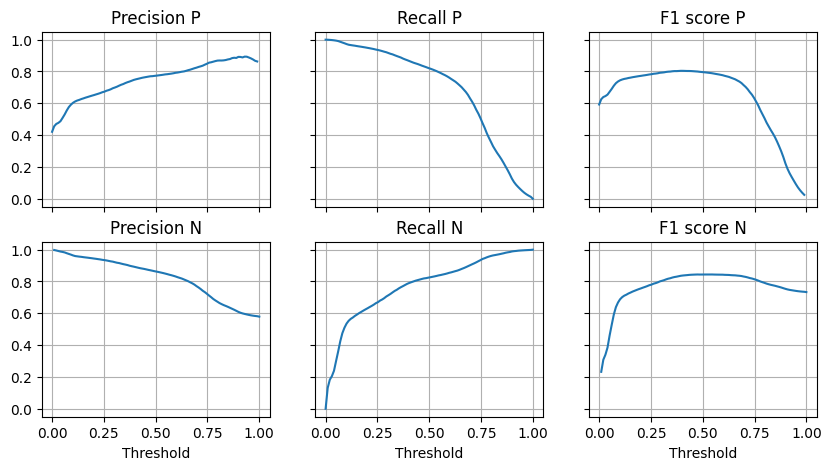

In [107]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [109]:
logistic.coef_[0]

array([ 1.32816736, -1.71735378,  0.20348991,  0.04611186,  0.78629312,
       -0.68800647, -0.77771304,  0.63944623,  0.65183923, -0.48227537,
        0.22069734, -0.03176323, -0.05025271,  0.11303783,  0.03559326,
       -0.06388986, -0.05748523,  0.07530475, -0.01054796, -0.0114209 ,
        0.00774938, -0.05221037, -0.04338567,  0.43599808, -0.3463864 ,
        0.11626946, -0.66817309,  0.35987721,  0.34126497, -0.2926607 ,
       -0.23352592, -0.48227537])

In [112]:
training_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

In [127]:
df_bar_chart = pd.DataFrame({'feature' : train_features.columns, 'coefficient':logistic.coef_[0]})
df_bar_chart = df_bar_chart.sort_values(by='coefficient')
df_bar_chart.head()

,feature,coefficient
1,age_upon_intake_(years),-1.717354
6,sex_upon_outcome_Intact Male,-0.777713
5,sex_upon_outcome_Intact Female,-0.688006
26,intake_type_Wildlife,-0.668173
31,sex_upon_intake_Unknown,-0.482275


<Axes: ylabel='feature'>

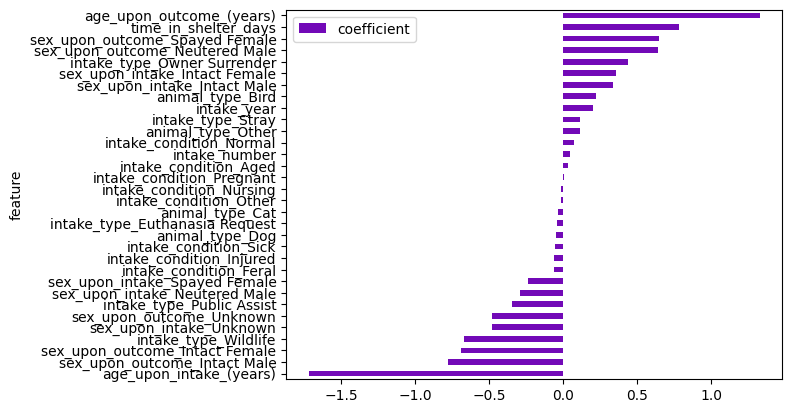

In [128]:
df_bar_chart.plot.barh(x = 'feature', color='#7209b7')


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95